# NL2SQL Github Demo

### This project is still under development and might not be suitable for all POC / Production use cases. To enable continuous improvements, this  project is heavily logged, so please be mindful of the information you share here. Please ensure that the data you want to test this on has already been loaded into BigQuery (or any other accessible database) and that the current user has the appropriate database permissions.

## Environment Setup

In [ ]:
PROJECT_ID = "<project-id>"

PROJECT_ID = PROJECT_ID.strip()

if not PROJECT_ID:
  raise RuntimeError("Please provide a valid Project ID")

from google.colab import auth
from IPython.display import HTML, display, clear_output
from google.colab import data_table

auth.authenticate_user()
activeaccounts = !gcloud config get-value account
!gcloud config set project $PROJECT_ID


BRANCH = "dev"
!pip install -qq git+https://github.com/GoogleCloudPlatform/nl2sql.git@{BRANCH}
!pip install loguru -qq

import warnings
import vertexai
from loguru import logger
from sqlalchemy.exc import SAWarning
vertexai.init(project=PROJECT_ID, location="us-central1")
logger.disable("nl2sql.commons.reporting.fingerprint")
warnings.filterwarnings("ignore", category=SAWarning)
!pip install -qq ipython-autotime
%load_ext autotime
clear_output()
display(
  HTML(
    f"""
    <h1><span>Installed NL2SQL Library</span></h1>
    <span>Installed Branch : <code>{BRANCH}</code></span>
    """
  )
)

## Dataset Setup
If you already have a BQ dataset you want to try with NL2SQL, please provide the name of the dataset in `dataset_name` below.

If you want to try NL2SQL with a dummy dataset, leave this blank and we will create a dummy dataset in the project defined above.

In [ ]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

client = bigquery.Client()

dataset_name = " "
dataset_name = dataset_name.strip()
bigquery_connection_string = None
if dataset_name:
  print(f"Checking if dataset {dataset_name} exists in {PROJECT_ID}.")
  try:
    client.get_dataset(f"{PROJECT_ID}.{dataset_name}")
  except NotFound as e:
    raise RuntimeError(
      f"Dataset {dataset_name} does not exist in {PROJECT_ID}. Please provide a"
      f" valid dataset name, or leave the field blank to use a dummy dataset."
    ) from e
  else:
    print("Dataset found, proceeding.")
    bigquery_connection_string = f"bigquery://{PROJECT_ID}/{dataset_name}"
else:
  dataset_name = "libraries_io"
  try:
    client.get_dataset(f"{PROJECT_ID}.{dataset_name}")
    print(
      f"The dummy dataset {dataset_name} is already present in {PROJECT_ID}. "
      f"This dataset will be used henceforth, please ensure it has valid data."
    )
    bigquery_connection_string = f"bigquery://{PROJECT_ID}/{dataset_name}"
  except NotFound as e:
    !gcloud services enable bigquerydatatransfer.googleapis.com
    !bq mk --dataset --location=US {PROJECT_ID}:{dataset_name}
    !bq cp --clone -n bigquery-public-data:libraries_io.dependencies {PROJECT_ID}:libraries_io.dependencies
    !bq cp --clone -n bigquery-public-data:libraries_io.projects {PROJECT_ID}:libraries_io.projects
    !bq cp --clone -n bigquery-public-data:libraries_io.projects_with_repository_fields {PROJECT_ID}:libraries_io.projects_with_repository_fields
    !bq cp --clone -n bigquery-public-data:libraries_io.repositories {PROJECT_ID}:libraries_io.repositories
    !bq cp --clone -n bigquery-public-data:libraries_io.repository_dependencies {PROJECT_ID}:libraries_io.repository_dependencies
    !bq cp --clone -n bigquery-public-data:libraries_io.tags {PROJECT_ID}:libraries_io.tags
    !bq cp --clone -n bigquery-public-data:libraries_io.versions {PROJECT_ID}:libraries_io.versions
    clear_output()
    bigquery_connection_string = f"bigquery://{PROJECT_ID}/libraries_io"
  finally:
    print(
      "\n", "="*25, "\n",
      f"\ndataset_name = \"{dataset_name}\"",
      f"\nbigquery_connection_string = \"{bigquery_connection_string}\"\n"
    )

# Basic Workflow

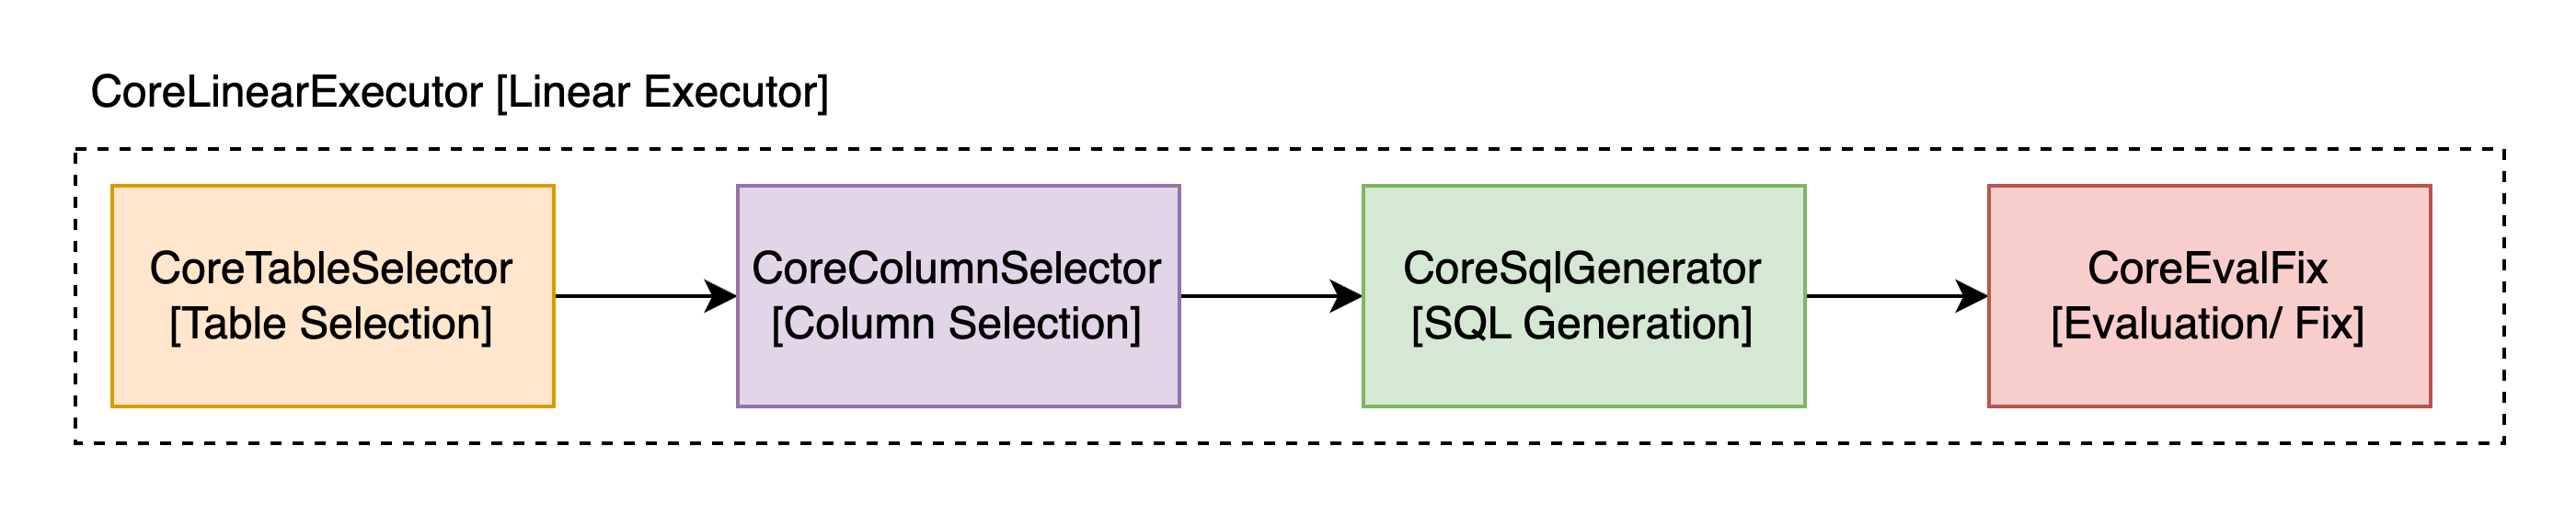

## Executor Setup

In [ ]:
from nl2sql.executors.linear_executor.core import CoreLinearExecutor

executor = CoreLinearExecutor.from_connection_string_map(
    {
        dataset_name: bigquery_connection_string
    }
)
print("\n\n", "="*25, "Executor Created", "="*25, "\n\n")
print("Executor ID :", executor.executor_id)

## SQL Generation

In [ ]:
result = executor(
    db_name= dataset_name,
    question = "What is the name of the project with the highest source rank?"
)
print("\n\n", "="*50, "Generated SQL", "="*50, "\n\n")
print("Result ID:", result.result_id, "\n\n")
print(result.generated_query)

## SQL Execution

In [ ]:
df = executor.fetch_result(result)
data_table.DataTable(df)

# Using Few Shot Chain of Thoughts

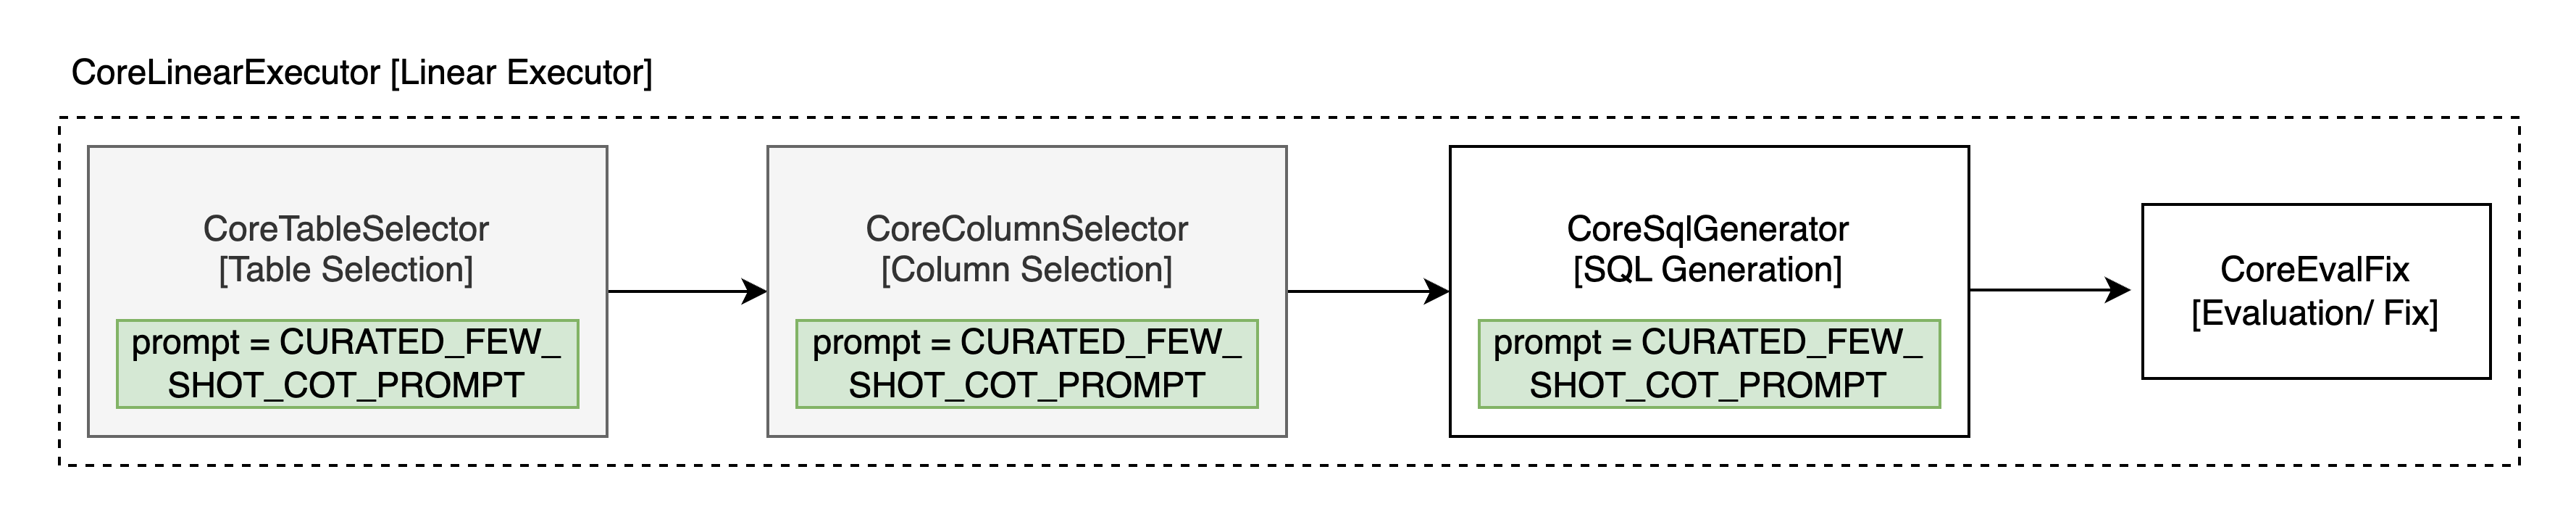

## Executor Setup

In [ ]:
from nl2sql.llms.vertexai import VertexAI
from nl2sql.executors.linear_executor.core import CoreLinearExecutor
from nl2sql.tasks.table_selection.core import CoreTableSelector, prompts as cts_prompts
from nl2sql.tasks.column_selection.core import CoreColumnSelector, prompts as ccs_prompts
from nl2sql.tasks.sql_generation.core import CoreSqlGenerator, prompts as csg_prompts

llm = VertexAI(model_name="gemini-1.5-flash-001")

# Disabling logs because these steps generate a LOT of logs.
logger.disable("nl2sql.datasets.base")
core_table_selector = CoreTableSelector(llm=llm, prompt=cts_prompts.CURATED_FEW_SHOT_COT_PROMPT)
core_column_selector = CoreColumnSelector(llm=llm, prompt=ccs_prompts.CURATED_FEW_SHOT_COT_PROMPT)
core_sql_generator = CoreSqlGenerator(llm=llm, prompt=csg_prompts.CURATED_FEW_SHOT_COT_PROMPT)
logger.enable("nl2sql.datasets.base")

cot_executor = CoreLinearExecutor.from_connection_string_map(
    {
        dataset_name: bigquery_connection_string
    },
    core_table_selector = core_table_selector,
    core_column_selector = core_column_selector,
    core_sql_generator = core_sql_generator
)

## SQL Generation

In [ ]:
cot_result = cot_executor(
    db_name= dataset_name,
    question = "Top 10 individual projects with the highest number of runtime dependencies"
)
print("\n\n", "="*50, "Generated SQL", "="*50, "\n\n")
print("Result ID:", cot_result.result_id, "\n\n")
print(cot_result.generated_query)

## SQL Execution

In [ ]:
cot_df = cot_executor.fetch_result(cot_result)
data_table.DataTable(cot_df)

# Excel File
## Using Sample Data from Excel File.

- Each Sheet in this file Represents a sample table with sheetname representing the Table name.
- Each Sheet has some sample rows/example records.
- There are two special Sheets in the Excel File i.e.
    - **Primary Key** : Key Value Style Representation where First Column i.e. "*Table*" is Tablename/Sheetname and Second Column i.e. "*Primary Key*" is a comma seprated list of columns representing Primary Key in that table.
    - **Foreign Key** : Contains Three Columns where First Column i.e. "*Table*" is Tablename/Sheetname and Second Column i.e. "*Foreign Key* " is a single value representing the Foreign Key Column in the associated Table. The Third Column i.e. "*References*" is the Reference Column where each value is of type "*Reference Table (Reference Key Column)*" to represent the referential integrity between the table relationships

## Executor Setup

### Download the [Sample Excel File](https://github.com/GoogleCloudPlatform/nl2sql/blob/main/getting-started/dataset/custom-dataset.xlsx)

The original `classicmodels` sql dataset can be found [here](https://gist.github.com/prof3ssorSt3v3/796ebc82fd8eeb0b697effaa1e86c3a6).

In [ ]:
from nl2sql.llms.vertexai import VertexAI
from nl2sql.executors.linear_executor.core import CoreLinearExecutor

llm = VertexAI(model_name="gemini-1.5-flash-001")

excel_filepath = "/content/custom-dataset.xlsx"
gcp_project_id = PROJECT_ID
dataset_name = "custom_dataset"

excel_file_executor = CoreLinearExecutor.from_excel(
                            filepath=excel_filepath,
                            project_id=gcp_project_id,
                            dataset_name=dataset_name
                        )



## SQL Generation

In [ ]:
excel_file_result = excel_file_executor(
    db_name=dataset_name,
    question="What is the average order price?"
)

print("\n\n", "="*50, "Generated SQL", "="*50, "\n\n")
print("Result ID:", excel_file_result.result_id, "\n\n")
print(excel_file_result.generated_query)

## SQL Execution

In [ ]:
df = excel_file_executor.fetch_result(excel_file_result)
data_table.DataTable(df)

# Disabling Table and Column Selection, and using ReAct for SQL Generation with a Larger Context model (Experimental)

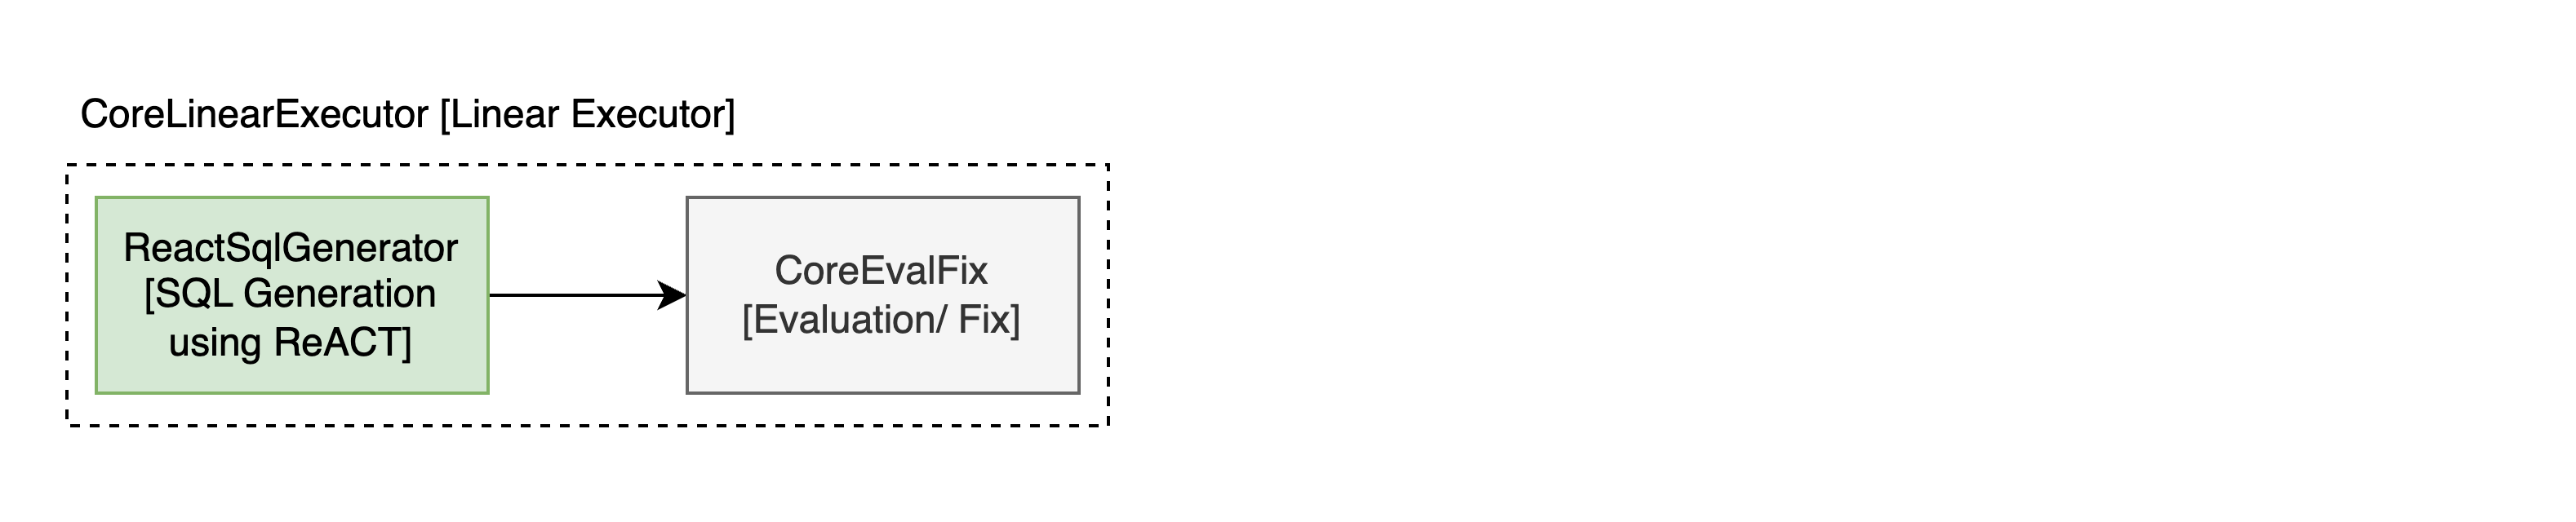

## Executor Setup

In [ ]:
from nl2sql.llms.vertexai import VertexAI
from nl2sql.executors.linear_executor.core import CoreLinearExecutor
from nl2sql.tasks.sql_generation.react import ReactSqlGenerator

llm = VertexAI(model_name="gemini-1.5-pro-001")

react_executor = CoreLinearExecutor.from_connection_string_map(
    {
        dataset_name: bigquery_connection_string
    },
    core_table_selector = None,
    core_column_selector = None,
    core_sql_generator = ReactSqlGenerator(llm=llm)
)

## SQL Generation

In [ ]:
react_result = react_executor(
    db_name= dataset_name,
    question = "Top 10 project names with the highest number of published versions"
)
print("\n\n", "="*50, "Generated SQL", "="*50, "\n\n")
print("Result ID:", react_result.result_id, "\n\n")
print(react_result.generated_query)

## SQL Execution

In [ ]:
react_df = react_executor.fetch_result(react_result)
data_table.DataTable(react_df)